In [1]:
import librosa
import librosa.display
import obspy
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py
import tsfel
import pandas as pd
import csv
import wave

In [2]:
# getting wav_files_paths
wav_files_paths = []

# open the CSV file in read mode
with open('wav_files_paths.csv', 'r') as file:
    reader = csv.reader(file)
    # Iterate through the rows in the CSV file
    for row in reader:
        # Append each row to the list
        wav_files_paths.append(row[0])

print(wav_files_paths[0])
print(wav_files_paths[30])

./data/wav/OS_7_05_2019_08_24_00_.wav
./data/wav/rpi-port-townsend_2019_11_14_14_28_00.wav


In [3]:
# converting annotations.tsv into df
annotations_file_path = './data/annotations.tsv'
df = pd.read_csv(annotations_file_path, sep='\t')
df.head()

,dataset,wav_filename,start_time_s,duration_s,location,date,pst_or_master_tape_identifier
0,podcast_round1,60012.wav,34.126,2.918,"Dabob Bay, Seattle, Washington",1960-10-28,60012
1,podcast_round1,60012.wav,36.816,2.588,"Dabob Bay, Seattle, Washington",1960-10-28,60012
2,podcast_round1,60012.wav,42.550,2.055,"Dabob Bay, Seattle, Washington",1960-10-28,60012
3,podcast_round1,60012.wav,44.606,2.410,"Dabob Bay, Seattle, Washington",1960-10-28,60012
4,podcast_round1,60012.wav,46.636,3.425,"Dabob Bay, Seattle, Washington",1960-10-28,60012


In [4]:
# find number of unique filenames in annotations.tsv
num_unique_filenames = df['wav_filename'].nunique()
print(num_unique_filenames)

2863


In [5]:
# find number of unique filenames in wav directory
!find ./data/wav -type f | wc -l

# since num wav files > num filenames in annotations.tsv, I will iterate through the
# ones in annotations.tsv

2976


In [6]:
# Remove rows from df where the filename doesn't correspond to an actual wav file
indices_to_drop = []
file_path = "data/wav/"
for index, row in df.iterrows():
    filename = df.loc[index, 'wav_filename']
    if not os.path.isfile(file_path + filename):
        indices_to_drop.append(index)

print(indices_to_drop)
df = df.drop(indices_to_drop)

[]


In [7]:
# create orca_call_df which has cols wav_filename, start_time_s, end_time_s

# create new df with cols wav_filename, start_time_s as cols
orca_call_df = df[['wav_filename', 'start_time_s']]

# add end_time_s col by adding duration_s to start_time_s
orca_call_df['end_time_s'] = df['start_time_s'] + df['duration_s']

orca_call_df

/tmp/ipykernel_1779412/2355072858.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orca_call_df['end_time_s'] = df['start_time_s'] + df['duration_s']


,wav_filename,start_time_s,end_time_s
0,60012.wav,34.126,37.044
1,60012.wav,36.816,39.404
2,60012.wav,42.550,44.605
3,60012.wav,44.606,47.016
4,60012.wav,46.636,50.061
...,...,...,...
5532,rpi-port-townsend_2020_09_08_14_55_00.wav,0.000,0.000
5533,rpi-port-townsend_2020_09_08_14_28_00.wav,0.000,0.000
5534,rpi-port-townsend_2020_10_08_02_25_00.wav,0.000,0.000
5535,rpi-port-townsend_2020_09_08_15_30_00.wav,0.000,0.000


In [8]:
# REMOVE DATA WHERE OVERLAPPING WHALE CALLS IN SAME AUDIO FILES
# functions to help removes all rows from df that have given filename
def remove_filenames(df, filenames_list):
  for filename in filenames_list:
    df = remove_filename(df, filename)
  return df

def remove_filename(df, filename):
  df = df.reset_index(drop=True)
  df = df[df['wav_filename'] != filename]
  return df

def find_rows_to_be_deleted(df):
    to_drop_filename = []
    for i in range(len(df) - 1):
        if (df.loc[i, 'wav_filename'] == df.loc[i + 1, 'wav_filename'] and 
            df.loc[i, 'end_time_s'] > df.loc[i + 1, 'start_time_s']):
          to_drop_filename.append(df.loc[i, 'wav_filename'])
    return to_drop_filename

In [9]:
to_drop_filename = find_rows_to_be_deleted(orca_call_df)
orca_call_df = remove_filenames(orca_call_df, to_drop_filename)
orca_call_df

,wav_filename,start_time_s,end_time_s
0,92303001.wav,0.0,1.059
1,92303002.wav,0.0,1.107
2,92303003.wav,0.0,1.306
3,92303004.wav,0.0,1.466
4,92303005.wav,0.0,2.026
...,...,...,...
2992,rpi-port-townsend_2020_09_08_14_55_00.wav,0.0,0.000
2993,rpi-port-townsend_2020_09_08_14_28_00.wav,0.0,0.000
2994,rpi-port-townsend_2020_10_08_02_25_00.wav,0.0,0.000
2995,rpi-port-townsend_2020_09_08_15_30_00.wav,0.0,0.000


In [10]:
# REMOVE DATA WHERE START_TIME_S = END_TIME_S = 0
orca_call_df = orca_call_df[~((orca_call_df['start_time_s'] == 0) & (orca_call_df['end_time_s'] == 0))]
orca_call_df.shape

(2416, 3)

In [11]:
# REMOVE DATA WHERE END_TIME_S > LENGTH OF AUDIO FILE
filenames_to_be_removed = []
for index, row in orca_call_df.iterrows():
    filename = row['wav_filename']
    filepath = 'data/wav/' + filename
    if not os.path.isfile(filepath):
        print(f"File not found: {filepath}")
        continue
    start_time = row['start_time_s']  # Keep in seconds
    end_time = row['end_time_s']  # Keep in seconds
    audio, sr = librosa.load(filepath)
    audio_length = len(audio) / sr
    if end_time > audio_length:
        filenames_to_be_removed.append(filename)
        
print(len(filenames_to_be_removed))

59


In [12]:
orca_call_df = orca_call_df[~orca_call_df['wav_filename'].isin(filenames_to_be_removed)]
orca_call_df.shape

(2347, 3)

In [13]:
# CREATING NOISE_DF
# create wav_filenames_len_dict which contains wav_filename and total_length
directory = './data/wav'

# initialize lists to store filenames and lengths
filenames = []
lengths = []

# iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.wav'):
        file_path = os.path.join(directory, filename)
        
        # load wav file
        y, sr = librosa.load(file_path, sr=None)
        # calculate length in seconds
        length = librosa.get_duration(y=y, sr=sr)
        
        # append the filename and length to the lists
        filenames.append(filename)
        lengths.append(length)

# creating dict where keys are wav_filenames and values are total_lengths
wav_filenames_len_dict = dict(zip(filenames, lengths))

In [14]:
print(len(wav_filenames_len_dict))

2975


In [15]:
noise_df = pd.DataFrame()

In [16]:
for wav_filename in wav_filenames_len_dict:
    if wav_filename in orca_call_df['wav_filename'].values:
        # create df with only rows of orca_call_df
        times_df = orca_call_df[orca_call_df['wav_filename'] == wav_filename][['start_time_s', 'end_time_s']]
        times_df = times_df.sort_values(by='start_time_s')
        times = []
        # fills times list with times in times_df
        for index, row in times_df.iterrows():
          times.append(row['start_time_s'])
          times.append(row['end_time_s'])
        # add 0 or length of audio file if necessary
        noise_start_index = 1
        # adding 0 if necessary:
        if times[0] != 0: # if whale call doesn't start at 0s
            times.insert(0, 0)
            noise_start_index = 0
        # adding length of audio file if necessary
        if times[len(times)-1] != wav_filenames_len_dict[wav_filename]: # if whale call doesn't end when the wav file ends
            length = wav_filenames_len_dict[wav_filename]
            times.insert(len(times), length)
        # populate noise_df
        if noise_start_index == 0:
            while len(times) > 1: # times is not empty
                new_row = {'wav_filename': wav_filename, 'start_time_s': times[0], 'end_time_s': times[1]}
                times.pop(0)
                times.pop(0)
                noise_df = pd.concat([noise_df, pd.DataFrame([new_row])], ignore_index=True)
        else: # noise_start_index = 1 eg: [0, 3.6, 4.0, 6.0, 7.7, 10]
            times.pop(0)
            while len(times) > 1: # times is not empty
                new_row = {'wav_filename': wav_filename, 'start_time_s': times[0], 'end_time_s': times[1]}
                times.pop(0)
                times.pop(0)
                noise_df = pd.concat([noise_df, pd.DataFrame([new_row])], ignore_index=True)

noise_df

,wav_filename,start_time_s,end_time_s
0,1562337136_0010.wav,0.000000,14.451172
1,1562337136_0010.wav,16.221680,47.755859
2,1562337136_0010.wav,49.765625,56.895508
3,1562337136_0010.wav,59.240234,61.250000
4,1562337136_0012.wav,0.000000,31.508298
...,...,...,...
2211,rpi-port-townsend_2020_09_29_19_33_00.wav,7.126267,7.735750
2212,rpi-port-townsend_2020_09_29_19_33_00.wav,9.235750,28.505067
2213,rpi-port-townsend_2020_09_29_19_33_00.wav,30.802083,37.412900
2214,rpi-port-townsend_2020_09_29_19_33_00.wav,38.912900,40.600967


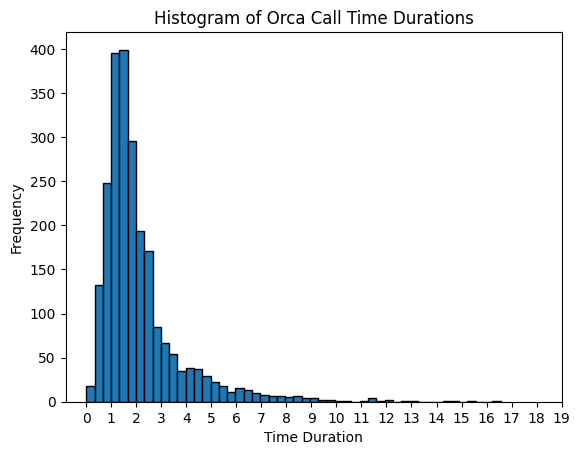

In [17]:
# SEEING HISTOGRAM FOR TIME DURATIONS OF ORCA CALLS
orca_durations = pd.DataFrame()
orca_durations['durations'] = orca_call_df['end_time_s'] - orca_call_df['start_time_s']
orca_durations_list = orca_durations['durations'].tolist()

# Create the histogram
plt.hist(orca_durations_list, bins=50, edgecolor='black')

# Add title and labels
plt.title('Histogram of Orca Call Time Durations')
plt.xlabel('Time Duration')
plt.ylabel('Frequency')

plt.xticks(range(0, 20, 1))

# Show the plot
plt.show()

# Most orca calls have a time duration of 1s. 

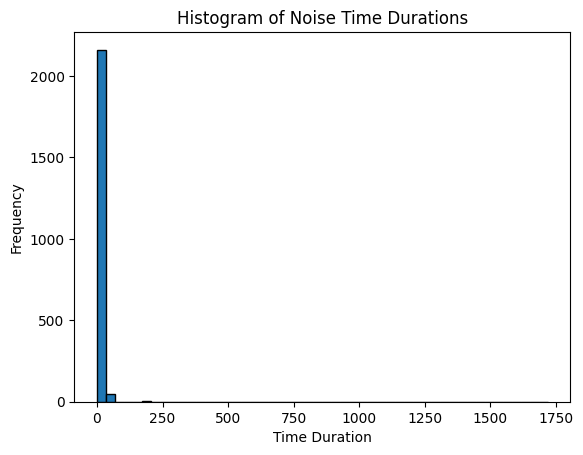

In [18]:
# SEEING HISTOGRAM FOR TIME DURATIONS OF ORCA CALLS
noise_durations = pd.DataFrame()
noise_durations['durations'] = noise_df['end_time_s'] - noise_df['start_time_s']
noise_durations_list = noise_durations['durations'].tolist()

# Create the histogram
plt.hist(noise_durations_list, bins=50, edgecolor='black')

# Add title and labels
plt.title('Histogram of Noise Time Durations')
plt.xlabel('Time Duration')
plt.ylabel('Frequency')

# Show the plot
plt.show()


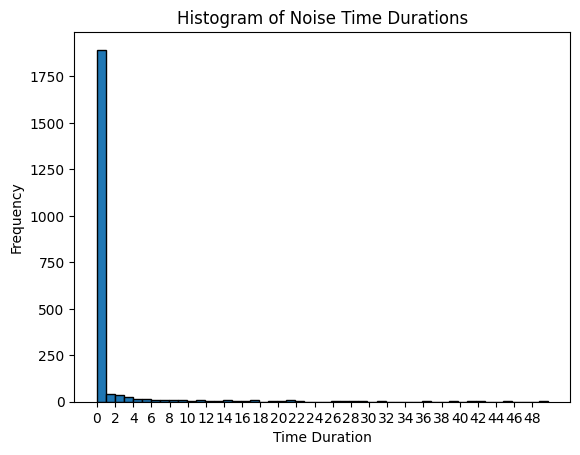

In [19]:
# Still unclear, so removing all values from list higher than 50
noise_durations_list = [value for value in noise_durations_list if value <= 50]

# Create the histogram
plt.hist(noise_durations_list, bins=50, edgecolor='black')

plt.xticks(range(0, 50, 2))

# Add title and labels
plt.title('Histogram of Noise Time Durations')
plt.xlabel('Time Duration')
plt.ylabel('Frequency')

# Show the plot
plt.show()

# Most noise calls have a time duration of 1s. 

In [20]:
# Remove rows from orca_call_df where duration < 1s
indices_to_be_removed = []
for index, row in orca_call_df.iterrows():
    if row['end_time_s'] - row['start_time_s'] < 1:
        indices_to_be_removed.append(index)
    else:
        orca_call_df.at[index, 'end_time_s'] = row['start_time_s'] + 1
        
orca_call_df.shape

(2347, 3)

In [21]:
if indices_to_be_removed: 
    orca_call_df = orca_call_df.drop(index=indices_to_be_removed)

In [22]:
# Remove rows from noise_df where duration < 1s
indices_to_be_removed = []
for index, row in noise_df.iterrows():
    if row['end_time_s'] - row['start_time_s'] < 1:
        indices_to_be_removed.append(index)
    else:
        noise_df.at[index, 'end_time_s'] = row['start_time_s'] + 1

In [23]:
if indices_to_be_removed: 
    noise_df = noise_df.drop(index=indices_to_be_removed)

In [24]:
noise_df.shape

(322, 3)

In [27]:
# saving clean orca_call_df to csv file
csv_file_path = './data/orca_data.csv'
orca_call_df.to_csv(csv_file_path, index=False)

# saving clean noise_df to csv file
csv_file_path = './data/noise_data.csv'
noise_df.to_csv(csv_file_path, index=False)